# Text Classification

Here we have a labeled dataset containing news text and its respective categories in the newspaper. In this notebook, we will use it to train an NLP classifier capable of predicting the label of a new text.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the dataset and keeping only letters in the text

In [2]:
df = pd.read_csv('bbc-text.csv')

In [3]:
df['text'] = df['text'].replace('[^a-zA-Z]', ' ', regex=True)

## Checking data balance

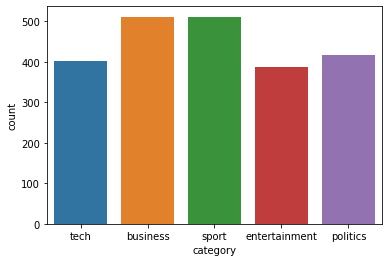

In [4]:
sns.countplot(x='category', data=df)

## Converting string categories to numerical

In [5]:
df['category_id'] = df['category'].factorize()[0]

In [6]:
df[['category_id','category']].drop_duplicates()

,category_id,category
0,0,tech
1,1,business
2,2,sport
4,3,entertainment
5,4,politics


In [7]:
# Storing the convertion in a dictionary
d = dict(df[['category_id','category']].drop_duplicates().values)

## Vectorizing text

By vectorizing, we can represent text with numbers by computing their frequency on the corpus. To prevent ending up with a bag of loose words, we can quantify combination of n-words (n-grams) such that we capture the meaning of sequences of words.

To minimize the computational burden of the task and to prevent taking into account sequences of unrelated words, we will limit the vectorization to 3-grams. Also, we will only vectorize words that have a minimum frequency of 5 and a maximum of 100. This way, we avoid feeding our model rare and general terms.

To check whether the words combinations are making sense, we will take a look at the most frequent n-grams for each category.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
def print_most_common_n_grams(df, min_gram, max_gram):
    d = {i : [] for i in range(min_gram, max_gram+1)}

    for col in df.columns:
        gram = len(col.split())
        column_sum = df[col].sum()
        d[gram].append((col, column_sum))

    for i in range(min_gram, max_gram+1):
        print ('Most common {}-gram'.format(i))
        d[i].sort(key=lambda x: x[1], reverse=True)
        most_common = [key[0] for key in d[i][:5]]
        for j in range(len(most_common)):
            print ('    {}. {}'.format(j+1, most_common[j]))

def get_most_common_n_grams_by_category(min_gram, max_gram, df, text_column_name, label_column_name):
    tfid = TfidfVectorizer(min_df=5,
                   max_df=100,
                   encoding='latin-1',
                   ngram_range=(min_gram, max_gram),
                   stop_words='english')

    tfid.fit(df[text_column_name])

    all_labels = df[label_column_name].unique()

    for label in all_labels:
        print ('LABEL: ', label)
        aux = df[df[label_column_name] == label]
        vectorized_text = tfid.transform(aux[text_column_name]).toarray()
        temp = pd.DataFrame(vectorized_text, columns=tfid.get_feature_names())
        print_most_common_n_grams(temp, min_gram, max_gram)
        print ('---------------')

In [26]:
get_most_common_n_grams_by_category(1, 3, df, 'text', 'category')

LABEL:  tech
Most common 1-gram
    1. microsoft
    2. broadband
    3. phones
    4. apple
    5. search
Most common 2-gram
    1. mobile phone
    2. high definition
    3. mobile phones
    4. news website
    5. wi fi
Most common 3-gram
    1. bbc news website
    2. digital music players
    3. bbc world service
    4. peer peer networks
    5. open source software
---------------
LABEL:  business
Most common 1-gram
    1. china
    2. yukos
    3. profits
    4. india
    5. stock
Most common 2-gram
    1. economic growth
    2. oil prices
    3. stock market
    4. analysts said
    5. bn euros
Most common 3-gram
    1. bn euros bn
    2. securities exchange commission
    3. london stock exchange
    4. reuters news agency
    5. high oil prices
---------------
LABEL:  sport
Most common 1-gram
    1. chelsea
    2. rugby
    3. champion
    4. arsenal
    5. liverpool
Most common 2-gram
    1. champions league
    2. world cup
    3. australian open
    4. grand slam
    5. ne

The results look good, however we do have some anomalies. For instance: the most frequent 3-gram for technology is 'bbc news website' and the third most frequent 3-gram for politics is 'told bbc radio'.

We will try to correct it by simply removing some words from the original text

In [27]:
def remove_list_of_words(x):
    aux = x
    for word in ['told', 'said', 'bbc']:
        aux = aux.replace(word, '')
    return aux

df['text'] = df['text'].apply(remove_list_of_words)


In [28]:
get_most_common_n_grams_by_category(1, 3, df, 'text', 'category')

LABEL:  tech
Most common 1-gram
    1. microsoft
    2. broadband
    3. phones
    4. apple
    5. search
Most common 2-gram
    1. mobile phone
    2. high definition
    3. mobile phones
    4. news website
    5. wi fi
Most common 3-gram
    1. digital music players
    2. peer peer networks
    3. open source software
    4. anti virus software
    5. high definition tv
---------------
LABEL:  business
Most common 1-gram
    1. china
    2. yukos
    3. profits
    4. india
    5. stock
Most common 2-gram
    1. economic growth
    2. oil prices
    3. stock market
    4. bn euros
    5. consumer spending
Most common 3-gram
    1. bn euros bn
    2. securities exchange commission
    3. london stock exchange
    4. reuters news agency
    5. high oil prices
---------------
LABEL:  sport
Most common 1-gram
    1. chelsea
    2. rugby
    3. champion
    4. arsenal
    5. liverpool
Most common 2-gram
    1. champions league
    2. world cup
    3. australian open
    4. grand slam
 

By running the function again, we can see that 'bbc news website' and 'told bbc radio' have been replaced by 'digital music player' and 'tory leader michael' (tory is an expression for the british conservative party).

In [29]:
tfidf = TfidfVectorizer(min_df=5,
                        max_df=100,
                        encoding='latin-1',
                        ngram_range=(1, 3),
                        stop_words='english')

X = tfidf.fit_transform(df['text']).toarray()
y = df['category_id']

## Cross Validating

LogisticRegression
LinearSVC
MultinomialNB
BernoulliNB


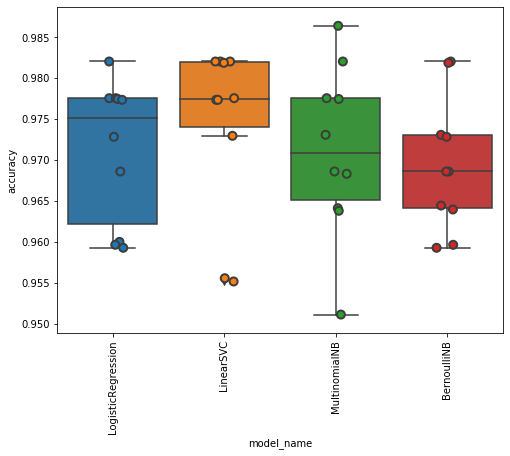

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = [
    LogisticRegression(),
    LinearSVC(),
    MultinomialNB(),
    BernoulliNB()
]

agg = []
for model in models:
    model_name = model.__class__.__name__
    print (model_name)
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=10)
    for accuracy in accuracies:
        agg.append((model_name, accuracy))
        

cv_df = pd.DataFrame(agg, columns=['model_name', 'accuracy'])



plt.figure(figsize=(8,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=90)

plt.show()


## Building a Linear SVC Classifier and Measuring its performance

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
clf = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1001)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [33]:
round(accuracy_score(y_test, y_pred), 3)

0.97

Text(0.5, 51.0, 'Predicted')

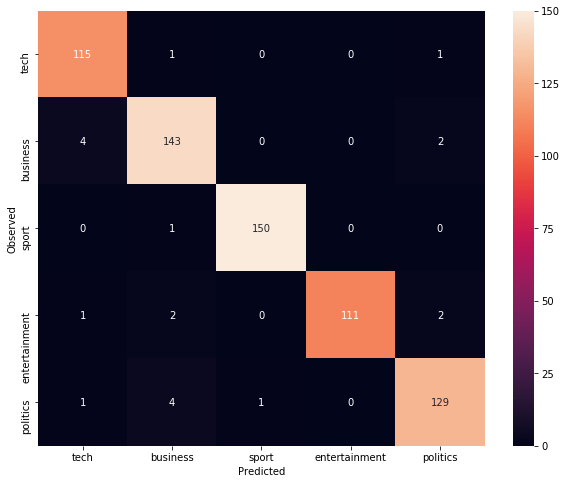

In [34]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat,
                 annot=True,fmt='d',
                 xticklabels=d.values(),
                yticklabels=d.values())

# Fix heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Insert x and y axis names
plt.ylabel('Observed')
plt.xlabel('Predicted')

## Conclusion 

In this project, we were able to create a very efficacious classifier without facing big difficulties. However, its simplicity and success were mainly thanks to two aspects: 
    1. We didn't have to deal with abreviations and spelling errors, since journalists write in standard English.
    2. Texts have very distinct subjects, and therefore little intersection of words. It becomes easy for a model to identify each category's vocabulary pattern.

In terms of computational burden, we can see that the application of NLP without cloud data processing is limited. By vectorizing the news text, we split the words into 13.6k columns, and, for 2.2k records, the process consumed 242Mb from memory. Had the dataset contained 220k records and no new vocabulary, the data structure would require over 20GB of free RAM to allocate it in memory - which is beyond most of the computers' setups.